In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🚴 Bike Sharing Demand 🚴

### It has become the preferred mode of transport and the pastime of choice for millions of people in the coronavirus era. The interest in cycling has come from commuters keen to avoid public transport because of the increased risk of infection and furloughed workers with time on their hands seeking a simple form of recreation. Vehicle traffic also fell sharply in many cities due to lockdowns, tempting cyclists on to the roads.
### The global market for Bicycles estimated at 29 Billion in the year 2020, is projected to reach a revised size of 34 Billion by 2027.
****
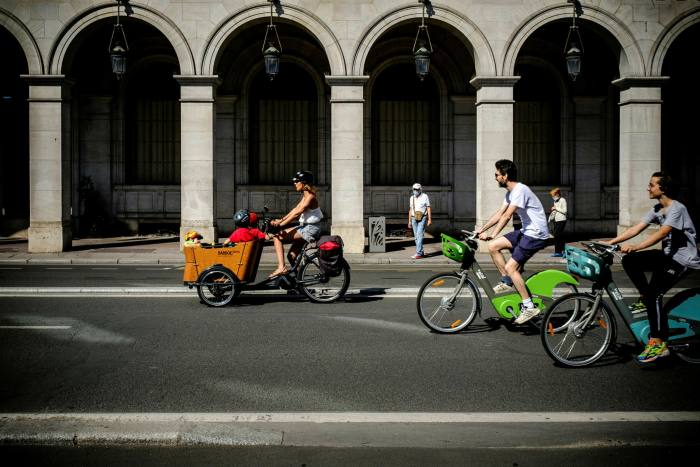

### In this Notebook we will try to combine historical usage patterns with weather data in order to predict and forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### The Dataset provides hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 
We'll predict the total count/demand of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

## Features:

### * datetime - hourly date + timestamp  
### * season -  
            1 = spring 
            2 = summer
            3 = fall
            4 = winter 
### * holiday - whether the day is considered a holiday
### * workingday - whether the day is neither a weekend nor holiday
### * weather -
            1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Rain + Thunderstorm + Scatter clouds, Rain + Scatter clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
### * temp - temperature in Celsius
### * atemp - "feels like" temperature in Celsius
### * humidity - relative humidity
### * windspeed - wind speed
### * casual - number of non-registered user rentals initiated
### * registered - number of registered user rentals initiated
### * count - number of total rentals

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv("../input/bike-datasets/train.csv", parse_dates = ["datetime"])
df.head()

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
df.isna().sum()

### Drop casual and register columns as we considering weather conditions in our problem

In [ ]:
df = df.drop(["casual", "registered"], axis = 1)
df.head()

In [ ]:
# add time paramteters to enrich datafarame

df["year"] = df.datetime.dt.year
df["month"] = df.datetime.dt.month
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df.head()

In [ ]:
# drop datetime column
df = df.drop(["datetime"], axis = 1)
df.head()

In [ ]:
# Copy dataframe
df_new = df.copy()
df_new.head()

In [ ]:
# visualize dataframe
df_new.hist(figsize = (20, 10));

### Notice that we have normal distibution on (Temp, atemp, humidity, windspeed)

In [ ]:
fig = plt.figure(figsize = (20, 10))
fig.add_subplot(221, xlabel ="Temp").scatter(df_new["temp"], df_new["count"],c="red", s=25)
fig.add_subplot(222, xlabel ="Feels Like").scatter(df_new["atemp"], df_new["count"],c="orange", s=25)
fig.add_subplot(223, xlabel ="Humidity").scatter(df_new["humidity"], df_new["count"],c="green", s=25)
fig.add_subplot(224, xlabel ="Windspeed").scatter(df_new["windspeed"], df_new["count"],c="blue", s=25)
plt.tight_layout();

In [ ]:
plt.scatter(df_new["hour"], df_new["count"], s =15, c="green");

### High demand during work opening/closing hours (7:00-8:00)AM and (17:00-18:00)PM

In [ ]:
plt.scatter(df_new["month"], df_new["count"], s =15, c="brown");

### Lowest demand during winter months (Jan-Feb)

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
np.random.seed(9)
X = df_new.drop("count", axis = 1)
y = df_new["count"]

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.25)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Modelling using Random Forest regressor
from sklearn.ensemble import RandomForestRegressor
np.random.seed(9)
model = RandomForestRegressor()
model.fit(X_train, y_train)

In [ ]:
y_preds = model.predict (X_test)

## Required evaluation metric is Root Mean Squared Logarithmic Error (RMSLE)

In [ ]:
# Create function for evaluations
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score 
def rmsle (y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def model_score(model):
    scores = {"MAE" : mean_absolute_error(y_test, y_preds),
              "RMSLE" : rmsle(y_test, y_preds),
              "R2" : r2_score(y_test, y_preds)}
    eval = rmsle(y_test, y_preds)
    print (f"Model RMSLE = {eval:.3f}")
    return scores

In [ ]:
model_score(model)

In [ ]:
## Use test datset
df_test = pd.read_csv("../input/bike-datasets/test.csv", parse_dates=["datetime"])
df_test.head()

In [ ]:
# test dataset preprocessing

df_test["year"] = df_test.datetime.dt.year
df_test["month"] = df_test.datetime.dt.month
df_test["day"] = df_test.datetime.dt.day
df_test["hour"] = df_test.datetime.dt.hour

df_test.head()

In [ ]:
df_final = df_test.drop("datetime", axis = 1)
df_final.head()

In [ ]:
y_preds_final = model.predict(df_final)

In [ ]:
df_eval = pd.DataFrame()
df_eval["datetime"] = df_test["datetime"]
df_eval["count"] = y_preds_final

In [ ]:
df_eval.head(10)

In [ ]:
df_eval.to_csv("final.csv", sep = ",", index = False)